<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Импорты" data-toc-modified-id="Импорты-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Импорты</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Извлечение-признаков-и-разбиение-на-выборки" data-toc-modified-id="Извлечение-признаков-и-разбиение-на-выборки-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Извлечение признаков и разбиение на выборки</a></span></li><li><span><a href="#Константная-модель" data-toc-modified-id="Константная-модель-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Константная модель</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

## Описание проекта 
В нашем распоряжении - исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Основные шаги:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Импорты

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor, cv, Pool
from lightgbm import LGBMRegressor

import optuna

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

# from pylab import rcParams
# rcParams['figure.figsize'] = 9, 5

sns.set(style='whitegrid', color_codes=True, font_scale = 1.2)
pd.options.display.max_rows = 400

RANDOM_STATE = 12345

## Подготовка

In [3]:
try:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col=['datetime']) #путь для ревьюера
except FileNotFoundError:
    df = pd.read_csv('datasets/taxi.csv',  parse_dates=['datetime'], index_col=['datetime'])

In [4]:
df.info()
display(df.head(10))
display(df.tail(10))
df.describe()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


,num_orders
datetime,
2018-08-31 22:20:00,48
2018-08-31 22:30:00,41
2018-08-31 22:40:00,34
2018-08-31 22:50:00,34
2018-08-31 23:00:00,30
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
# проверка на хронологический порядок
df.index.is_monotonic

True

In [6]:
# ресемплируем данные по одному часу
df = df.resample('1H').sum()

## Анализ

In [7]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
decomposed = seasonal_decompose(df)

Text(0.5, 1.0, 'Resid')

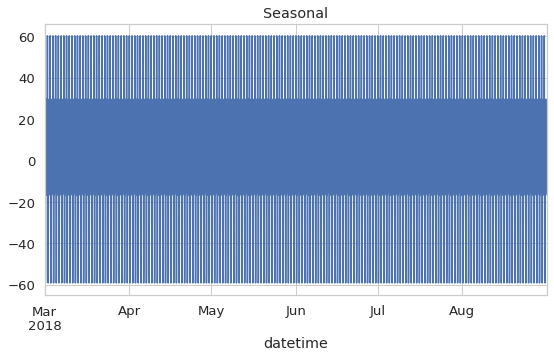

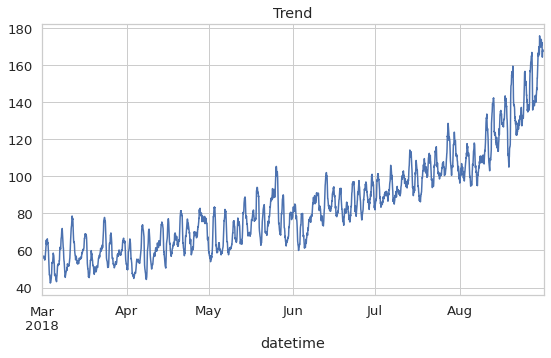

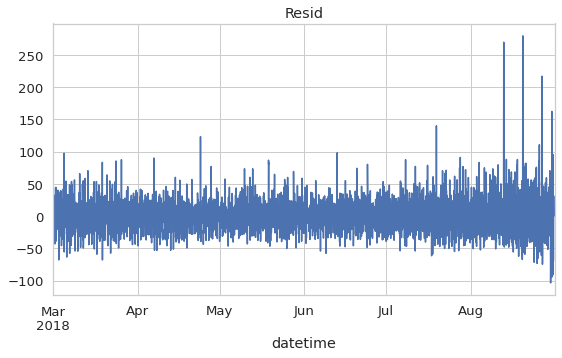

In [9]:
# plt.figure(figsize = (11, 5))
fig, ax = plt.subplots(figsize=(9, 5))
decomposed.seasonal.plot(ax=ax).set_title('Seasonal')

fig1, ax1 = plt.subplots(figsize=(9, 5))
decomposed.trend.plot(ax=ax1).set_title('Trend')

fig2, ax2 = plt.subplots(figsize=(9, 5))
decomposed.resid.plot(ax=ax2).set_title('Resid')




Вывод:  
* Явно можно выделить тренд на увеличение заказов
* Периодическая составляющая и остатки в текщем виде не объяснимы

Text(0.5, 1.0, 'Seasonal')

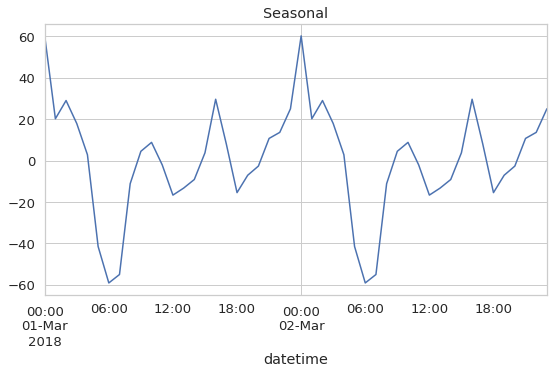

In [10]:
# изменим масштаб рассмотрения
decomposed.seasonal['2018-03-01': '2018-03-02'].plot(figsize=(9,5)).set_title('Seasonal')

В данном масштабе можно явно выделить паттерн количства заказов внутри суток

## Обучение

Порядок следующий:
* Создадим признаки
* Разобьем данные на выборки
* Посмотрим на бэйслайн метрики константных моделей
* Пострим различные модели: линейная регрессия, случайный лес, бустинг.
* Кросс-валидируем их и подберем гиперпараметры для модели, показавшей лучший результат на валидации


### Извлечение признаков и разбиение на выборки
Нагенерим признаки и добавим автокорреляцию ("отстающие" значения)

In [11]:
def make_features(data: pd.core.frame.DataFrame, max_lag: int, rolling_mean_size: int):
    '0 - ночь, 1 - утро, 2 - день, 3 - вечер'
    data_ext = data.copy()
    data_ext['month'] = data.index.month
    data_ext['day'] = data.index.day
    data_ext['dayofweek'] = data.index.dayofweek
    data_ext['is_weekend'] = np.ones(shape=data.shape) 

#     интересная запись, я ее взял из интернета. False*1 = 0, True*1 = 1
#     день недели считается с 0
    data_ext['is_weekend'] = data.index.dayofweek.isin([5,6])*1
    
    data_ext.loc[(data.index.hour >= 0) & (data.index.hour <= 6), 'daytime'] = 0
    data_ext.loc[(data.index.hour >= 7) & (data.index.hour <= 11), 'daytime'] = 1
    data_ext.loc[(data.index.hour >= 12) & (data.index.hour <= 17), 'daytime'] = 2
    data_ext.loc[(data.index.hour >= 18) & (data.index.hour <= 23), 'daytime'] = 3
    data_ext['daytime'] = data_ext['daytime'].astype('int32')
    data_ext['hour'] = data.index.hour
     
    for lag in range(1, max_lag + 1):
        data_ext[f'lag_{lag}'] = data['num_orders'].shift(lag)
        
    data_ext['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    data_ext['seasonal'] = decomposed.seasonal
    
#     сразу удалим пропуски, появившиеся из за shift(lag)
    data_ext = data_ext.dropna() 
    
    return data_ext

Не знаю насколько полезно было добавлять категориальный признак daytime, но глядя на график периодической составляющей внутри суток, показалось, что в этом что то есть

In [12]:
df_ext = make_features(df, 48, 5)


(0.0, 250.0)

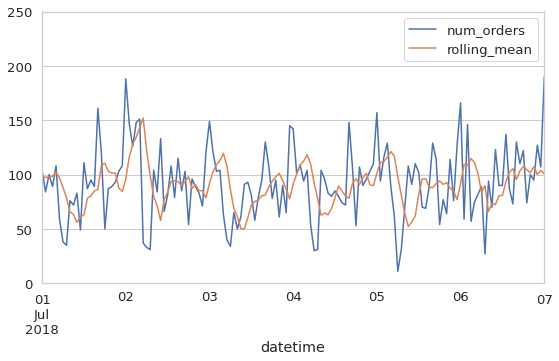

In [13]:
df_ext[['num_orders', 'rolling_mean']].plot(figsize=(9, 5))
plt.xlim('2018-07-01', '2018-07-07')
plt.ylim(0, 250)

In [14]:
features = df_ext.drop('num_orders', axis = 1)
target = df_ext['num_orders']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, shuffle=False) 

In [15]:
display(features_train)
display(features_test)

,month,day,dayofweek,is_weekend,daytime,hour,lag_1,lag_2,lag_3,lag_4,...,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean,seasonal
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,3,3,5,1,0,0,72.0,119.0,101.0,93.0,...,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,86.8,60.248112
2018-03-03 01:00:00,3,3,5,1,0,1,163.0,72.0,119.0,101.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,109.6,20.177074
2018-03-03 02:00:00,3,3,5,1,0,2,108.0,163.0,72.0,119.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,112.6,28.982743
2018-03-03 03:00:00,3,3,5,1,0,3,25.0,108.0,163.0,72.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,97.4,17.885407
2018-03-03 04:00:00,3,3,5,1,0,4,64.0,25.0,108.0,163.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,86.4,2.791145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 14:00:00,8,13,0,0,2,14,119.0,92.0,144.0,156.0,...,105.0,84.0,102.0,62.0,122.0,174.0,143.0,73.0,129.6,-9.191665
2018-08-13 15:00:00,8,13,0,0,2,15,102.0,119.0,92.0,144.0,...,89.0,105.0,84.0,102.0,62.0,122.0,174.0,143.0,122.6,3.731832
2018-08-13 16:00:00,8,13,0,0,2,16,175.0,102.0,119.0,92.0,...,155.0,89.0,105.0,84.0,102.0,62.0,122.0,174.0,126.4,29.604100


,month,day,dayofweek,is_weekend,daytime,hour,lag_1,lag_2,lag_3,lag_4,...,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean,seasonal
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 19:00:00,8,13,0,0,3,19,104.0,152.0,144.0,175.0,...,157.0,177.0,174.0,155.0,89.0,105.0,84.0,102.0,135.4,-7.124270
2018-08-13 20:00:00,8,13,0,0,3,20,91.0,104.0,152.0,144.0,...,136.0,157.0,177.0,174.0,155.0,89.0,105.0,84.0,133.2,-2.696560
2018-08-13 21:00:00,8,13,0,0,3,21,82.0,91.0,104.0,152.0,...,111.0,136.0,157.0,177.0,174.0,155.0,89.0,105.0,114.6,10.670243
2018-08-13 22:00:00,8,13,0,0,3,22,160.0,82.0,91.0,104.0,...,51.0,111.0,136.0,157.0,177.0,174.0,155.0,89.0,117.8,13.596814
2018-08-13 23:00:00,8,13,0,0,3,23,104.0,160.0,82.0,91.0,...,22.0,51.0,111.0,136.0,157.0,177.0,174.0,155.0,108.2,25.000503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,8,31,4,0,3,19,207.0,217.0,197.0,116.0,...,232.0,217.0,216.0,265.0,177.0,170.0,191.0,169.0,174.0,-7.124270
2018-08-31 20:00:00,8,31,4,0,3,20,136.0,207.0,217.0,197.0,...,193.0,232.0,217.0,216.0,265.0,177.0,170.0,191.0,174.6,-2.696560
2018-08-31 21:00:00,8,31,4,0,3,21,154.0,136.0,207.0,217.0,...,186.0,193.0,232.0,217.0,216.0,265.0,177.0,170.0,182.2,10.670243


In [16]:
# создадим функцию для вывода основных метрик качества моделей регрессии
def regression_metrics(target, predictions):
    print(f'RMSE: {np.sqrt(mean_squared_error(target, predictions)):.2f}')
    print(f'MSE:  {mean_squared_error(target, predictions):.2f}')
    print(f'R2:   {r2_score(target, predictions):.4f}')
    print(f'MAE:  {mean_absolute_error(target, predictions):.2f}')
    print(f'MAPE: {mean_absolute_percentage_error(target, predictions):.2f}')
    print('_'*20)

### Константная модель

In [17]:
# константная модель
model_dummy = DummyRegressor().fit(features_train, target_train)

In [18]:
# создадим объект и используем его для кросс-валидации временных рядов в аргументе cv
tscv = TimeSeriesSplit(n_splits=5) 
cross_val_score(model_dummy, features_train, target_train, scoring='neg_root_mean_squared_error', cv=tscv).mean()

-40.5962612043412

Здесь и далее кроссвалидацию делал через TimeSeriesSplit. Из параметров объекта, оставил пока только n_splits

Остаьные достаточно специфические и позволяют оценить работу модели на ограниченных данных (max_train_size) - если есть заключение о том, что данные теряют свою актуальность за пол года, например, и мы хотим ограничить размер обучающей выборки, либо сымитировать поведение модели при наличии разрыва между обучающей выборкой и тестовой (gap), данное исследование может помочь с выявлением оптимального периода обучения модели в проде.

* [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) - корректно созданный объект данного класса можно передавать аргументом cv, тогда кросс-валидация будет корректной.
* [SciKit-Learn кратко о работе сего сплита](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split)
* [Более подробный туториал о кросс-валидации для временных рядов](https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/)

### Линейная регрессия

In [19]:
# линейная регрессия
model_lr = LinearRegression().fit(features_train, target_train)

In [20]:
cross_val_score(model_lr, features_train, target_train, scoring='neg_root_mean_squared_error', cv=tscv).mean()

-23.551133604455764

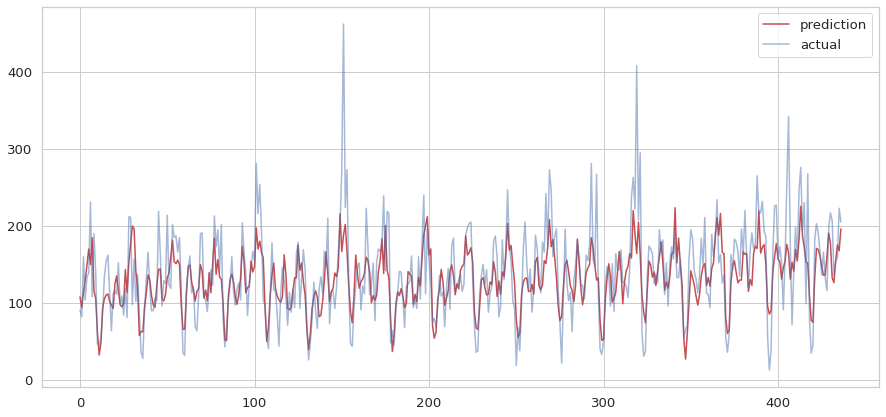

In [21]:
predictions = model_lr.predict(features_test)
plt.figure(figsize=(15, 7))
plt.plot(predictions, "r", label="prediction")
plt.plot(target_test.values, label="actual", alpha=0.5)
plt.legend(loc="best")

Форма повторяется, но мы сильно недопредсказываем

### Случайный лес

In [22]:
%%time 
# случайный лес
model_rf = RandomForestRegressor().fit(features_train, target_train)

CPU times: user 9.28 s, sys: 45.2 ms, total: 9.32 s
Wall time: 9.33 s


In [23]:
%%time 
cross_val_score(model_rf, features_train, target_train, scoring='neg_root_mean_squared_error', cv=tscv).mean()

CPU times: user 21.9 s, sys: 136 ms, total: 22.1 s
Wall time: 22.1 s


-23.866679402549067

<AxesSubplot:>

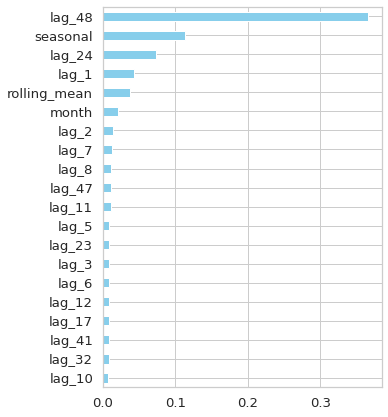

In [24]:
feat_imp = pd.Series(model_rf.feature_importances_, index=features_train.columns).nlargest(20).sort_values(ascending=True)
feat_imp.plot(kind='barh', figsize=(5,7), color='skyblue')


Нас интересуют таймлаги кратные 24 часам, т.к. они стали самыми весомыми признаками для модели и мы знаем, что паттерн поведения повторяется каждые 24 часа. Построим график, на котором отобразим тренд и тренд + сезонность с шагом в 24 часа. 
    
Графики полностью друг друга повторяют, лишь с разницей по оси y на константную величину - сезонность.
    
Когда ты добавляешь lag_24 в данные, то он уже несет в себе информацию как о сезонности, так и о тренде (плюс о шуме), следовательно его полезность окажется выше, чем только знание о константном отступе от тренда.
    
Исходя из этого можно подумать, что lag_24 и lag_48 можно заменить использованием rolling_mean за достаточно большой период, и seasonal признаком, но все не так просто - на графике ниже видно, что тренд растет с ощутимыми колебаниями, есть ощутимые выбросы вверх, если просто включить все эти данные в скользящее среднее, то значение получится завышенным и все последующие предсказания будут завышены, но если брать значение предшествующее пику, то оно в большинстве случаев будет близким к значению после пика. Модель данную закономерность тоже просекла, отчего и выбрала lag_48 как то значение, которое наилучшим образом характеризует целевой признак.

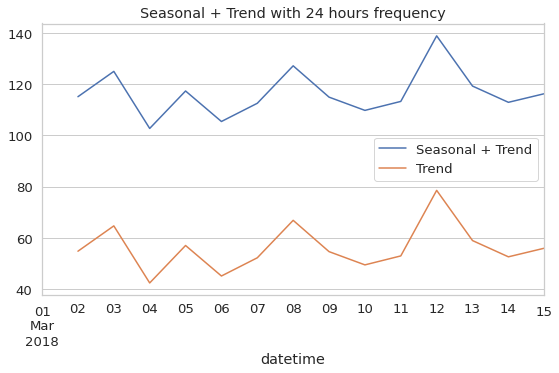

In [25]:
tmp = decomposed.trend['2018-03-01': '2018-03-15'] + decomposed.seasonal['2018-03-01': '2018-03-15']
plt.figure(figsize=(9,5))
tmp[::24].plot(label='Seasonal + Trend').set_title('Seasonal + Trend with 24 hours frequency');
decomposed.trend['2018-03-01': '2018-03-15'][::24].plot(label='Trend')
plt.legend();

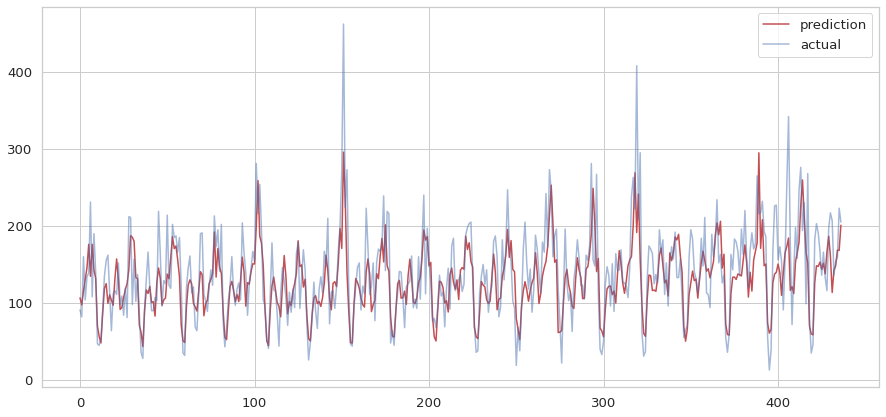

In [26]:
predictions = model_rf.predict(features_test)
plt.figure(figsize=(15, 7))
plt.plot(predictions, "r", label="prediction")
plt.plot(target_test.values, label="actual", alpha=0.5)
plt.legend(loc="best")

Вроде уже намного лучше.  
Попробуем подобрать гиперпараметры с помощью библиотеки Optuna:

In [27]:
import warnings
warnings.filterwarnings("ignore")

In [28]:
# зададим диапазоны параметров для OptunaSearchCV
params_search = {'n_estimators': optuna.distributions.IntUniformDistribution(10, 500, 10),
                  'max_depth': optuna.distributions.IntUniformDistribution(0, 15, 1)}
#                  'criterion': optuna.distributions.CategoricalDistribution(['squared_error', 'absolute_error', 'poisson']),
#                  'max_leaf_nodes': optuna.distributions.IntUniformDistribution(50, 351, 50),
#                  'min_samples_split': optuna.distributions.IntUniformDistribution(3, 22, 2),
#                  'min_samples_leaf': optuna.distributions.IntUniformDistribution(1, 22, 2),

model_os = RandomForestRegressor()

opt_search_rf = optuna.integration.OptunaSearchCV(
    model_os, params_search, cv=tscv, n_trials=15, scoring='neg_root_mean_squared_error', timeout=500)

In [29]:
# %%time

# opt_search_rf.fit(features_train, target_train)

In [30]:
# print(opt_search_rf.best_params_)
# opt_search_rf.best_score_

### LightGBM

In [31]:
%%time
model_lgbmr = LGBMRegressor(n_estimators=1000, learning_rate=0.01, random_state=RANDOM_STATE)
model_lgbmr.fit(features_train, target_train)

CPU times: user 15.9 s, sys: 63 ms, total: 16 s
Wall time: 16.1 s


LGBMRegressor(learning_rate=0.01, n_estimators=1000, random_state=12345)

In [32]:
%%time
# проверим метрику RMSE с помощью кроссвалидации
cross_val_score(model_lgbmr, features_train, target_train, scoring='neg_root_mean_squared_error', cv=tscv).mean()

CPU times: user 1min 5s, sys: 347 ms, total: 1min 6s
Wall time: 1min 6s


-23.595891622870028

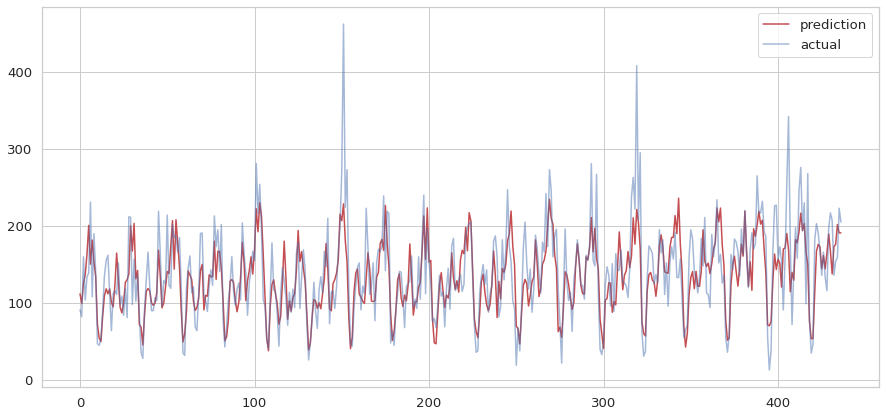

In [33]:
predictions = model_lgbmr.predict(features_test)
plt.figure(figsize=(15, 7))
plt.plot(predictions, "r", label="prediction")
plt.plot(target_test.values, label="actual", alpha=0.5)
plt.legend(loc="best")

In [34]:
# зададим диапазоны параметров для OptunaSearchCV
params_search = {'learning_rate': optuna.distributions.UniformDistribution(0.05, 0.5),
                'n_estimators': optuna.distributions.IntUniformDistribution(100, 1400, 100),
                'subsample': optuna.distributions.UniformDistribution(0.8, 1),
                'max_depth': optuna.distributions.IntUniformDistribution(0, 15, 1)}

model_os_lgbmr = LGBMRegressor()

opt_search_lgbmr = optuna.integration.OptunaSearchCV(
    model_os_lgbmr, params_search, cv=tscv, n_trials=20, scoring='neg_root_mean_squared_error', timeout=500)

In [35]:
%%time
opt_search_lgbmr.fit(features_train, target_train)

[I 2022-07-12 10:19:14,471] A new study created in memory with name: no-name-99141ec6-0dc0-4b85-acf9-3a18e98bbf72
[I 2022-07-12 10:19:33,063] Trial 0 finished with value: -24.36114304054319 and parameters: {'learning_rate': 0.19429281032731932, 'n_estimators': 400, 'subsample': 0.802145392606422, 'max_depth': 9}. Best is trial 0 with value: -24.36114304054319.
[I 2022-07-12 10:19:46,777] Trial 1 finished with value: -24.347696859806838 and parameters: {'learning_rate': 0.2448592024111566, 'n_estimators': 300, 'subsample': 0.9214869657592174, 'max_depth': 8}. Best is trial 1 with value: -24.347696859806838.
[I 2022-07-12 10:19:51,276] Trial 2 finished with value: -24.14368364332923 and parameters: {'learning_rate': 0.19749666070413247, 'n_estimators': 500, 'subsample': 0.9337342554829158, 'max_depth': 2}. Best is trial 2 with value: -24.14368364332923.
[I 2022-07-12 10:20:40,961] Trial 3 finished with value: -24.434738450473038 and parameters: {'learning_rate': 0.2584353659480269, 'n_es

CPU times: user 9min 1s, sys: 3.12 s, total: 9min 4s
Wall time: 9min 9s


OptunaSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
               estimator=LGBMRegressor(), n_trials=20,
               param_distributions={'learning_rate': UniformDistribution(high=0.5, low=0.05),
                                    'max_depth': IntUniformDistribution(high=15, low=0, step=1),
                                    'n_estimators': IntUniformDistribution(high=1400, low=100, step=100),
                                    'subsample': UniformDistribution(high=1.0, low=0.8)},
               scoring='neg_root_mean_squared_error', timeout=500)

In [36]:
print(opt_search_lgbmr.best_params_)
opt_search_lgbmr.best_score_

{'learning_rate': 0.05225961877423749, 'n_estimators': 1400, 'subsample': 0.8656573202428975, 'max_depth': 4}


-23.687597765443073

Для бустинга заметно переобучение. В данном случае можно констатировать избываточное количество итераций.
    
Проанализируем возможность утечки целевого признака. Что было сделано:
* таймлаги, на них утечка данных исключена, ибо они начинаются с 1 (иногда можно ошибиться и начать с 0, вот тогда была бы утечка).
* скользящее среднее - тут можно было ошибиться, но я исключил текущее значение из расчета скользящего среднего.
Утечки целевого признака быть не должно, лишь только автокорреляция, но для полного эффекта от нее нужно включить большее количество запаздывающих значений.
    
Само по себе скользящее среднее несет информацию о текущем тренде значений, это позволяет решить сразу два вопроса:
* Нестационарность ряда и слежение за трендом.
* Информацию о росте/спаде значений внутри периода, вместе с информацией о запаздывающих значениях за этот период модель лучше заучивает паттерны, выявленные при анализе сезонности.
    

## Тестирование
Проверим модели на тестовой выборке

In [37]:
# константная модель
regression_metrics(target_test, model_dummy.predict(features_test))

RMSE: 84.74
MSE:  7180.71
R2:   -1.0766
MAE:  68.27
MAPE: 0.48
____________________


In [38]:
# линейная регрессия
regression_metrics(target_test, model_lr.predict(features_test))

RMSE: 41.37
MSE:  1711.35
R2:   0.5051
MAE:  29.99
MAPE: 0.26
____________________


In [39]:
# случайный лес
regression_metrics(target_test, model_rf.predict(features_test))

RMSE: 39.87
MSE:  1589.77
R2:   0.5402
MAE:  29.46
MAPE: 0.24
____________________


In [40]:
# случайный лес c подобранными OptunaSearchCV гиперпараметрами
# regression_metrics(target_test, opt_search_rf.best_estimator_.predict(features_test))

In [41]:
regression_metrics(target_test, model_lgbmr.predict(features_test))

RMSE: 38.63
MSE:  1492.14
R2:   0.5685
MAE:  28.42
MAPE: 0.24
____________________


In [42]:
# LGBM c подобранными OptunaSearchCV гиперпараметрами
regression_metrics(target_test, opt_search_lgbmr.best_estimator_.predict(features_test))

RMSE: 39.16
MSE:  1533.63
R2:   0.5565
MAE:  28.76
MAPE: 0.24
____________________


**Вывод:**

Лучшее качество на тестовой выборке показала модель LightGBM.

Но если оценивать по графику предсказаний, кажется что RandomForest гораздо лучше повторяет форму исходных данных и ближе предскахывает в максимух функции.  
Эта способность лучше описывать пики может быть очень полезной, т.к. сильнее всего ощущается острая нехватка такси в пиковую загрузку, нежели чем легкий дефицит / переизбыток такси в обычное время (ну, это если смотреть со стороны клиента, со стороны таксистов наоборот интереснее собирать фиолетовые ценники собирать всегда из-за дефицита предложения). 

По собственным наблюдениям на качество модели очень сильно влияет количество сгенерированных "лагов". Например при lag=168 (неделя), RMSE обычной линейной регрессии - 34,85. У LGBMR 36.4

Но такое большое количество признаков сильно замедляет обучение и кросс-валидацию (особенно для Random Forest), поэтому оставил lag=48 (двое суток). Но заметил на графике feature_importance - наибольшая "важность" у последних лагов. Возможно целесообразно оставлять только несколько первых и последних лагов, либо генерировать признаки с шагом в 24 за неделю (lag_24, 48 ... 168).

Модель случайного леса и LGBRM с подобранными OptunaSearch гиперпараметрами на тестовой выбоке показала результат хуже, чем модели с параметрами по умолчанию. Возможно задал неудачные диапазоны гиперпараметров для перебора.

